## Boltzmann Exploration Temperature Sweep

Exploration parameters are hard to fit offline because they determine subsequent data collection and model estimation. In this notebook we use simulation to perform a hyperparameter sweep over Boltzmann exploration for recommendation.
<br/>
<br/>

In [34]:
import paths
%cd {paths.base}
from os.path import join

%load_ext autoreload
%autoreload 2
from simtrain import process_dat, utils, explore_models
from simtrain import SETTINGS_POLIMI as SETTINGS
from experiment import boltzmann_study as bolt

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import os
os.environ['NUMEXPR_MAX_THREADS'] = SETTINGS.NUMEXPR_MAX_THREADS

/root/notebooks/accordion
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
print('simulation components:', SETTINGS.simulation_components)

simulation components: {'ab_test_id': 'train', 'rec_model_cell_nbr': [1], 'user_model_cell_nbr': 1, 'visit_model_cell_nbr': 1}


In [36]:
# specify which data to load:
dat_all, stg_all = process_dat.load_dat(paths.cw_stages['output']['alldat'])

In [37]:
# pull out test datatasets:
cell_col = 'acnt.test_cell_nbr'
cells = {'train':1,
        'valid':2,
        'test_seen_users':3,
        'test_unseen_users':4}

train_dat = dat_all[dat_all[cell_col]==cells['train']]
test_dat_s = dat_all[dat_all[cell_col]==cells['test_seen_users']]
test_dat_u = dat_all[dat_all[cell_col]==cells['test_unseen_users']]

stg_tr = process_dat.get_settings(train_dat)
stg_s = process_dat.get_settings(test_dat_s)
stg_u = process_dat.get_settings(test_dat_u)

# adjust test time to start at zero:
start_time = train_dat.time.max()
stg_s['T'] = stg_s['T'] - start_time
stg_u['T'] = stg_u['T'] - start_time
print('settings test seen users',stg_s)

settings test seen users {'NI': 920, 'NU': 1247, 'T': 28.01816558837892, 'NS': 100, 'INF_TIME': 1000}


In [51]:
print('temperature sweep settings', SETTINGS.hyp['hyp_study']['temperature_sweep'])

temperature sweep settings [1, 0.5, 0.25, 0.125, 0.0625]


In [52]:
# time: retrain 3 days after start time, then every 7 days thereafter until end of test period
tevmin = test_dat_s.time.min()
tevmax = test_dat_s.time.max()
init_time_incr = 3
time_incr = 7
time_sweep = [tevmin, tevmin+init_time_incr] + list(np.arange(tevmin+init_time_incr+time_incr, tevmax, time_incr)) + [tevmax]
s_temp = {}
time_sweep

[70.00225830078125,
 73.00225830078125,
 80.00225830078125,
 87.00225830078125,
 94.00225830078125,
 97.99787902832031]

In [53]:
SETTINGS.hyp['hyp_study']

{'init_args': {'n_components': 10, 'init': 'random', 'random_state': 0},
 'temperature': 1.0,
 'temperature_sweep': [1, 0.5, 0.25, 0.125, 0.0625],
 'constant_rate': True}

In [89]:
# run sim both for PP (homogeneous) and iPP (inhomogeneous):
for rate_style in ['pp', 'ipp']:
    # supply configuration of recommender model to simulator:
    rec_model_config = [('train',1,99)]
    user_set = np.arange(20, dtype='int64')
    # perform temperature sweep and return a set of simulations:
    s_temp[rate_style] = bolt.simulate_temperature(user_set, bolt.user_activity(train_dat), \
                                       train_dat, test_dat_s, stg_tr, stg_s, rec_model_config, \
                                       time_sweep, rate_style)
    # save simulations:
    pp_sim_stem = join(paths.dat, '%s_sim_invT%f.csv.gz')
    for invT in SETTINGS.hyp['hyp_study']['temperature_sweep']:
        s_temp[rate_style][invT].to_csv(pp_sim_stem % (rate_style, invT))

INV TEMP 1
INV TEMP 0.5
INV TEMP 0.25
INV TEMP 0.125
INV TEMP 0.0625


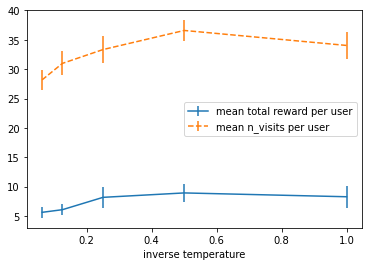

In [83]:
bolt.plot_temp_sweep(s_temp['ipp'], 'inhomogeneous') 

INV TEMP 1
INV TEMP 0.5
INV TEMP 0.25
INV TEMP 0.125
INV TEMP 0.0625


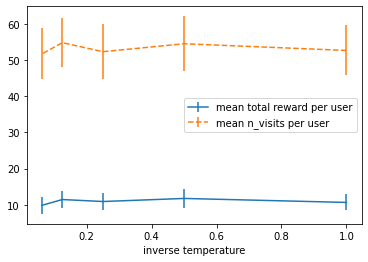

In [88]:
bolt.plot_temp_sweep(s_temp['pp'], 'homogenous')    